# Unordered Close Following Agents

May of you will be aware that Flatland agents cannot follow each other close behind, unless they are in agent index order, ie Agent 1 can follow Agent 0, but Agent 0 cannot follow Agent 1, unless it leaves a gap of one cell.

We have now provided an update which removes this restriction.  It's currently in the branch `323_unordered_cell_locking`.  It means that agents (moving at the same speed) can now always follow each other without leaving a gap.

**Why is this a big deal?  Or even a deal?**

Many of the OR solutions took advantage of it to send agents in the "correct" index order so that they could make better use of the available space, but we believe it's harder for RL solutions to do the same.

Think of a chain of agents, in random order, moving in the same direction. For any adjacent pair of agents, there's a 0.5 chance that it is in index order, ie index(A) < index(B) where A is in front of B.  So roughly half the adjacent pairs will need to leave a gap and half won't, and the chain of agents will typically be one-third empty space.  By removing the restriction, we can keep the agents close together and so move up to 50% more agents through a junction or segment of rail in the same number of steps.

**What difference does it make in practice?**

We have run a few tests and it does seem to slightly increase the training performance of existing RL models.

**Does the order not matter at all now?**

Well, yes, a bit.  We are still using index order to resolve conflicts between two agents trying to move into the same spot, for example, head-on collisions, or agents "merging" at junctions.

**This sounds boring.  Is there anything interesting about it at all?**

Thanks for reading this far... It was quite interesting to implement.  Think of a chain of moving agents in reverse index order.  The `env.step()` iterates them from the back of the chain (lowest index) to the front, so when it gets to the front agent, it's already processed all the others.  Now suppose the front agent has decided to stop, or is blocked.  The env needs to propagate that back through the chain of agents, and none of them can in fact move.  You can see how this might get a bit more complicated with "trees" of merging agents etc. And how do we identify a chain at all?

We did it by storing an agent's position as a graph node, and a movement as a directed edge, using the NetworkX graph library.  We create an empty graph for each step, and add the agents into the graph in order, using their (row, column) location for the node.  Stationary agents get a self-loop.  Agents in an adjacent chain naturally get "connected up".  We then use some NetworkX algorithms:
- `weakly_connected_components` to find the chains.  
- `selfloop_edges` to find the stopped agents
- `dfs_postorder_nodes` to traverse a chain
- `simple_cycles` to find agents colliding head-on 

We can also display a NetworkX graph very simply, but neatly, using GraphViz (see below).

**Does it run faster / slower?**

It seems to make almost no difference to the speed.

**How do you handle agents entering the env / spawning?**

For an agent in state READY_TO_DEPART we use a dummy cell  of `(-1, agent_id)`.  This means that if several agents try to enter the env in the same cell and in the same step, the agent with the lowest index will get to start first.  It uses the same rule as above, the agent with the lowest index gets to enter an empty cell ahead of any others.









In [1]:
%load_ext autoreload
%autoreload 2
from IPython.core import display 
display.display(display.HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import networkx as nx
import PIL
from IPython import display
import time

In [3]:
from flatland.envs import malfunction_generators as malgen
from flatland.envs.agent_utils import EnvAgent
from flatland.envs import rail_generators as rail_gen
from flatland.envs import agent_chains as ac
from flatland.envs.rail_env import RailEnv, RailEnvActions
from flatland.envs.persistence import RailEnvPersister
from flatland.utils.rendertools import RenderTool
from flatland.utils import env_edit_utils as eeu
from flatland.utils import jupyter_utils as ju

## Load the test cases

For now the test cases are in the same file as the code.  First we display them without detecting collisions / conflicts, just the motions.  

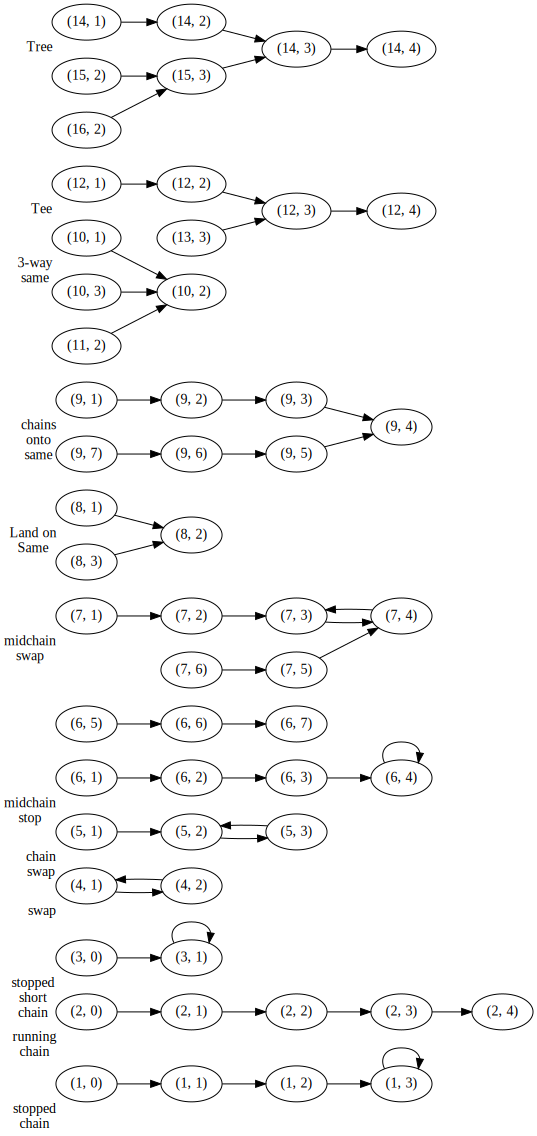

In [4]:
omc = ac.MotionCheck()
ac.create_test_agents2(omc)
ac.render(omc)

## Detect conflicts and re-render

We colour the nodes to indicate conflicts:
- Red means stopped
- Purple means a swap-over conflict (ie head-on collision where the agents are adjacent)
- Blue means an empty cell where two or more agents are trying to move in.
- Magenta means an agent vacating a cell, where two or more other agents are trying to move in.
- Black means no conflict, so an agent will move to the new cell.


In [5]:
omc.find_conflicts()

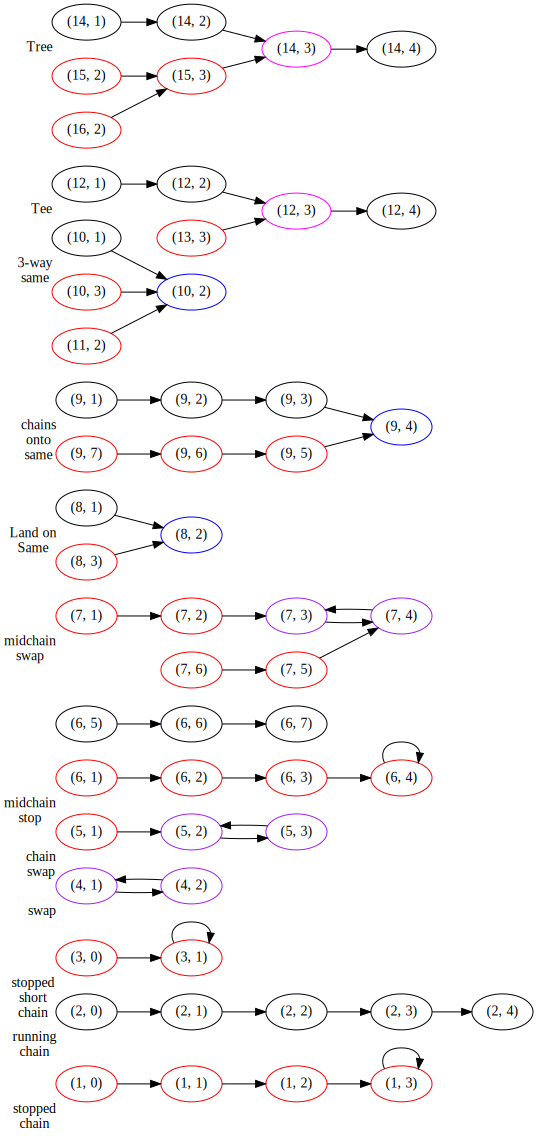

In [6]:
gvDot = ac.render(omc)
gvDot

## Load a test Env
Load an env and invoke the chain checker.  


In [16]:
env, envModel = eeu.makeTestEnv("merging_spurs", nAg=10, bUCF=True)
oEC = ju.EnvCanvas(env)
oEC.show()

Canvas(layout=Layout(height='300px', width='600px'), size=(600, 300))

Step: 0

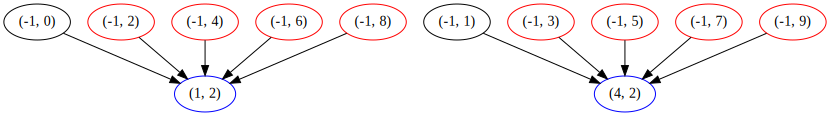

Step: 1

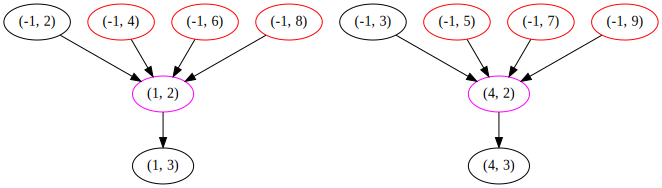

Step: 2

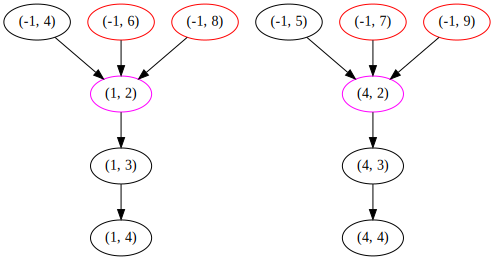

Step: 3

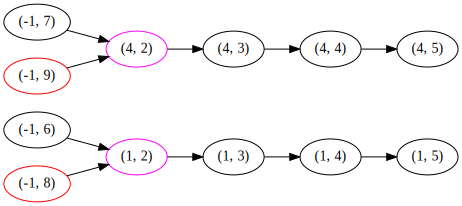

Step: 4

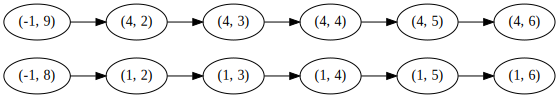

Step: 5

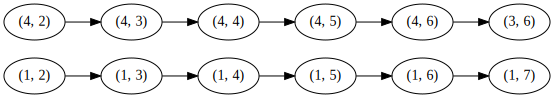

Step: 6

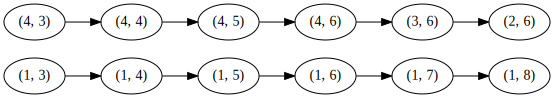

Step: 7

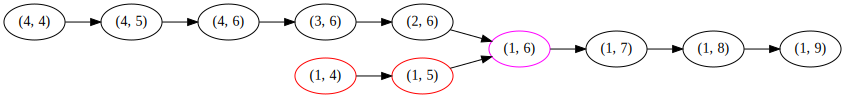

Step: 8

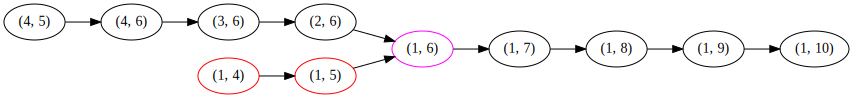

Step: 9

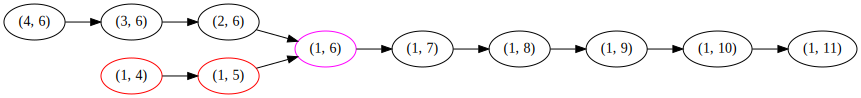

In [17]:
for i in range(10):
    oEC.step()
    oEC.render()
    
    display.display_html(f"<br>Step: {i}\n", raw=True)
    display.display_svg(ac.render(env.motionCheck, horizontal=(i>=3)))
    time.sleep(0.1)

In [26]:
dAgStateFrozen= {0: (1, 11, 1),
 1: (1, 8, 1),
 2: (1, 10, 1),
 3: (1, 7, 1),
 4: (1, 9, 1),
 5: (1, 6, 0),
 6: (1, 5, 1),
 7: (2, 6, 0),
 8: (1, 4, 1),
 9: (3, 6, 0)}

In [27]:
dAgState={}
for iAg, ag in enumerate(env.agents):
    dAgState[iAg] = (*ag.position, ag.direction)
assert dAgState == dAgStateFrozen
